# <center> Group 12 : "THE SHOW MUST GO ON" by Couch Potatoes </center> <span style="color: red;"> <center><font size="4"><u> Group Members</u>: Chi-Hao Tseng, Christopher Iacono, Poorna Nilkund, Wang-Han Li, Yi-Ching Lin, Yuru Chen </font></span>

## <center> Introduction </center>

Netflix's determination to add content among various countries outside of the United States drives its marketing strategy. Analysts in the entertainment streaming industry state their global expansion strategy is driven first and foremost by content released and offered. Customers want a variety of shows and movies that appeal to their particular lifestyles and cultures.

Attaining customers in different countries is just the beginning though, Netflix wants to maintain a longterm relationship with them. Quality of shows and movies is another significant factor for Netflix's strategy - ratings are an acceptable way to measure content but often can be misleading. Our dataset provides us with some key factors like ratings and availability for different languages and countries. So, we questioned how much and what kind of content they release in various countries and languages. We also questioned the ratings themselves - how does Netflix balance variety and quality of its content? How can we further understand content beyond just its rating?

We collected this data from Kaggle. It consists of all Netflix's movies and shows from April 2015 to March 2021 - about 15,000 movies and shows and nineteen columns describing the content. Important columns we utilized for our report and analysis were language availability, country availability, ratings, and the release date on Netflix. A lot of processing had to occur as there were thousands of null values particularly for ratings from Rotten Tomatoes - so we decided to webscrape information from the Rotten Tomatoes website to fill that. Twitter was also webscraped during the sentiment analysis portion of the report, up to ten thousand tweets were used for sentiment analysis.

## <center> Heavier Grading on DATA PROCESSING Part </center>

- The project should be graded on the Data Processing part because we have scraped a lot of data and also transformed the existing data set for visualizations. We scraped almost 15000 Netflix shows and movies to obtain their Rotten tomato scores and compared it with an already existing column for further analysis.

- We also had to request 'Extended' version access from Twitter to scrape tweets for top IMDb rated shows from the dataset. We further used this for sentiment analysis.

## <center> DATA PROCESSING </center>

### We will be loading the data. Here we go....

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Need to have a separate import for other configs due to https://github.com/jupyter/notebook/issues/3691
import matplotlib.pyplot as plt2
from wordcloud import WordCloud
from textwrap import wrap
import tweepy
from textblob import TextBlob
from collections import namedtuple
import urllib.parse
import requests
from bs4 import BeautifulSoup
import re
import warnings 
# remove warnings from Jupyter notebook
warnings.filterwarnings('ignore')

In [2]:
df_data = pd.read_csv('netflix-rotten-tomatoes-metacritic-imdb.csv',engine='python', encoding='latin')
# remove unnecessary columns
df_data = df_data.drop(columns=['View Rating','Genre', 'Tags', 'Runtime',  'Awards Nominated For', 'Boxoffice','Director','Writer', 'Actors','Metacritic Score','Production House','Summary','Image','Poster','TMDb Trailer','Trailer Site','Netflix Link','IMDb Link','IMDb Votes'])
df_data = df_data.loc[:, ~df_data.columns.str.contains('^Unnamed')]

### We will be using a separate dataframe to store the Country Availability and Netflix Release dates. We are making sure that only the YEAR is extracted from the entire Release Date

In [3]:
# choose the columns that would be useful on generating wordcloud
df_wordcloud = df_data[['Country Availability','Netflix Release Date']]

In [4]:
# transform the data type of release date to only show the year of the date, which would be helpful to see a general trend on the shifting of countries on Metflix
df_wordcloud['Netflix Release Date'] = df_wordcloud['Netflix Release Date'].astype(str).str[0:4]

In [5]:
# generate a list of the counts of each country that are avilable to the movies and films to use in the wordcloud 
stack_country = df_wordcloud['Country Availability'].str.split(',', expand=True).stack().value_counts()

## We take a look at country availability as a whole to get a glimpse on the most countries available on Netflix. 

### <span style="color:red"> Why did we create a Word Cloud? </span> <br> It's an effective way of engaging the audience. Just a glance at the word cloud, tells way more than what a simple chart could explain.

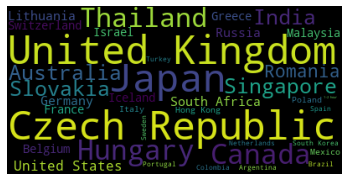

In [6]:
# generate wordcloud object
wordcloud = WordCloud()

# use the frequency that showed on the previous analysis and pass it in the function as an object
wordcloud.generate_from_frequencies(frequencies=stack_country)

# generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### ANALYSIS : 
- From the above Word Cloud, we can infer that almost 5 countries have same amount of content. While we analyzed the beginning years, only UK topped the charts but it's impressive to see that over the years NETFLIX has expanded to a great extent. Also, this article talks about how in 2015 Netflix was operating only in 50 countries but now it has expanded to 190.

#### Ref : https://en.wikipedia.org/wiki/International_expansion_of_Netflix

## Now, we will be taking a look at how over the years Netflix has diversified Movie content with respect to Language based on Title- Language Availability as well as Content from Different Countries

In [7]:
df_movie = df_data.set_index('Title')
# filter movie for analysis
df_movie = df_movie[(df_movie['Series or Movie'] == 'Movie')]
df_movie.head()

,Languages,Series or Movie,Hidden Gem Score,Country Availability,IMDb Score,Rotten Tomatoes Score,Awards Received,Release Date,Netflix Release Date
Title,,,,,,,,,
HOW TO BUILD A GIRL,English,Movie,7,Canada,5.8,79.0,1.0,8-May-20,3/4/2021
Centigrade,English,Movie,6.4,Canada,4.3,NaN,NaN,28-Aug-20,3/4/2021
Moxie,English,Movie,8.1,"Lithuania,Poland,France,Iceland,Italy,Spain,Gr...",6.3,NaN,NaN,22-Sep-11,3/4/2021
The Con-Heartist,Thai,Movie,8.6,Thailand,7.4,NaN,NaN,3-Dec-20,3/3/2021
Only a Mother,Swedish,Movie,8.3,"Lithuania,Poland,France,Italy,Spain,Greece,Bel...",6.7,NaN,2.0,31-Oct-49,3/3/2021


In [8]:
# count the top 5 languages for all movies
def current_year_top_3_language(df, year, k):
    language_stat = {}
    # select each year as first column
    current_year_data = df_movie[(df_movie['Netflix Release Date'].str.endswith(year))].reset_index()
    for i in range(len(current_year_data)):
        if isinstance(current_year_data['Languages'][i], str):
            languages = current_year_data['Languages'][i].split(', ')
            for lang in languages:
                language_stat[lang] = language_stat.get(lang, 0) + 1

    value_sort = list(sorted(language_stat.items(), key=lambda x: x[1], reverse=True))
    
    res = []
    for i in range(k):
        res.append(value_sort[i])
    return res

res_2016 = current_year_top_3_language(df_movie, '2016', k=5)
res_2017 = current_year_top_3_language(df_movie, '2017', k=5)
res_2018 = current_year_top_3_language(df_movie, '2018', k=5)
res_2019 = current_year_top_3_language(df_movie, '2019', k=5)
res_2020 = current_year_top_3_language(df_movie, '2020', k=5)

In [9]:
# build new df for top 5 languages over 2016-2020
df_lang_count = pd.DataFrame([res_2016,res_2017,res_2018,res_2019,res_2020], index=range(2016,2021))
df_lang_count = df_lang_count.rename(columns={0:'No.1',1:'No.2',2:'No.3',3:'No.4',4:"No.5"})
df_lang_count

,No.1,No.2,No.3,No.4,No.5
2016,"(English, 578)","(Japanese, 133)","(Spanish, 93)","(French, 82)","(Korean, 64)"
2017,"(English, 641)","(Japanese, 121)","(Hindi, 96)","(Spanish, 93)","(French, 71)"
2018,"(English, 710)","(Japanese, 149)","(Hindi, 146)","(Spanish, 140)","(French, 97)"
2019,"(English, 860)","(Japanese, 158)","(Spanish, 138)","(French, 128)","(Korean, 106)"
2020,"(English, 1140)","(Japanese, 236)","(French, 184)","(Spanish, 147)","(German, 97)"


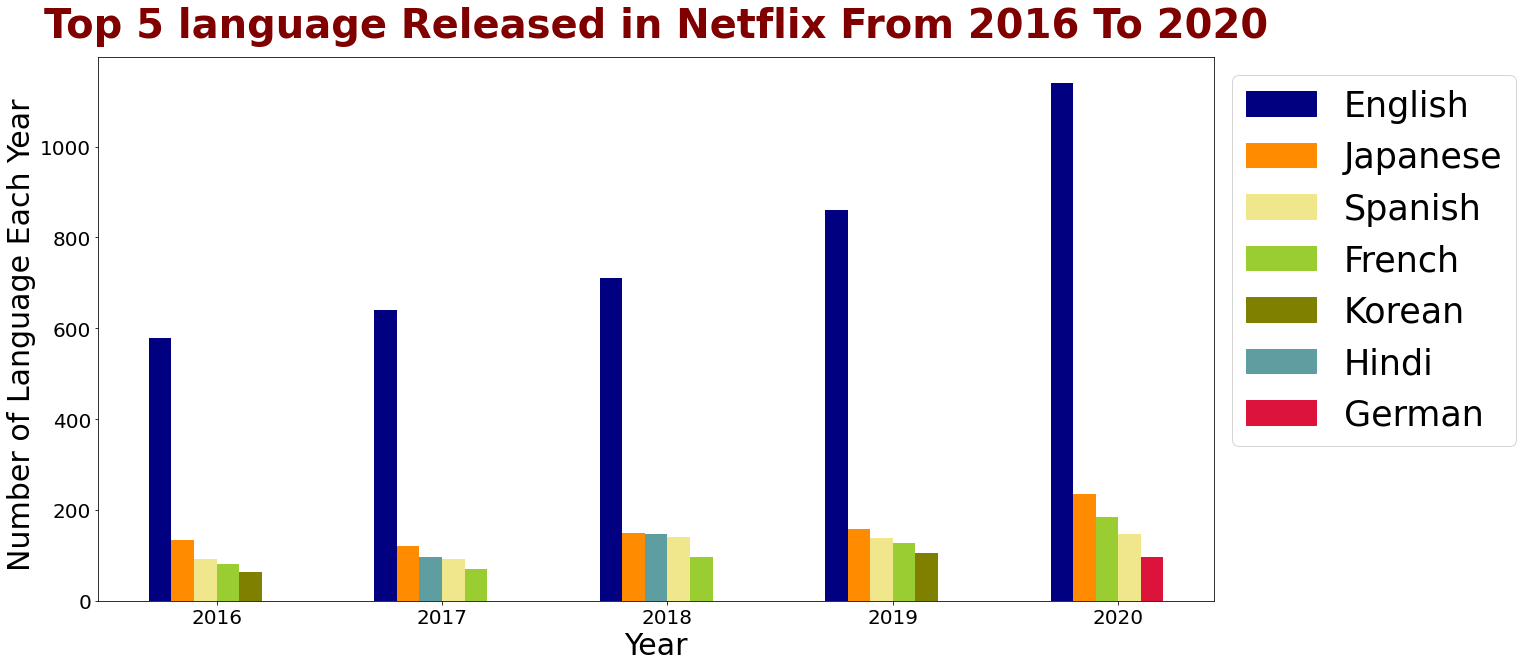

In [11]:
# set up x-axis and color set for graphs
x_axis = df_lang_count.index
colors = {'English':'navy', 'Japanese':'darkorange','Spanish':'khaki','French':'yellowgreen','Korean':'olive','Hindi':'cadetblue', 'German':'crimson'}

# plot top 5 languages count over years
for col_idx in range(len(df_lang_count.columns)):
    col = df_lang_count.columns[col_idx]
    bar = x_axis-0.25+0.1*col_idx
    language = [df_lang_count[col].iloc[i][0] for i in range(len(df_lang_count.index))]
    lang_count = [df_lang_count[col].iloc[i][1] for i in range(len(df_lang_count.index))]    
    # one language match up with one specific color
    lang_color = [colors[lang] for lang in language]
    plt.bar(bar, lang_count, 0.1, color=lang_color)
plt.ylabel('Number of Language Each Year ',fontsize= 30)
plt.yticks(fontsize=20)
plt.xlabel('Year',fontsize= 30)
plt.xticks(fontsize=20)
plt.title('Top 5 language Released in Netflix From 2016 To 2020', fontdict={'fontsize': 40, 'fontweight': 700, 'color': 'maroon'}, pad=20)
plt.rcParams['figure.figsize']=(20,10)
    
# plot legend of languages
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, bbox_to_anchor=(1.0, 1.0), prop={'size': 35})

### ANALYSIS : 
 - English is, unsurprisingly, one of the most popular languages accessible on Netflix. The number of English-language films has increased significantly, most likely as a result of the pandemic's frequent stay-at-home policies. As a United States company streaming primarily content made in the US, English availability is common in the majority of content. <br><br>
 - Netflix expanded their company to Asia in 2016. Netflix's huge investments in Japanese originals come at a time when Asia, and particularly Japan, was becoming increasingly essential to the streaming industry's development as a whole. We can observe that since 2016, there have been more movies available in Japanese by Japanese content creators. It is worth noting that American content is also regularly dubbed to Japanese, as certain shows and movies are growing in popularity there - increased Japanese content will likely result in more English dubs to viewers outside of Japan. <br> According to research, Netflix premiered in Japan at the end of September 2015, making it the first country in Asia to have the service available. Looking at the above bar chart, it also shows that the number of Japanese movies available has doubled between 2016 and 2020. <br><br> 
 - This increase demostrates that Korean or K-drama has become a target market for them since 2015 too. Netflix is clearly attempting to conjoin western and eastern markets in order to maximize global memberships while also satisfying unique cultures and lifestyles.

## We further go ahead and Analyze how USERS & CRITICS react to the Content they watch on Netflix....

IMDb requires registration by individual users in order to rate and critique movies and shows. A user's review is accounted for by a particular movie or show - IMDb aggregates these individuals' ratings according to their own standards and takes some average of them to gather a single consensus. This is a nuanced process that is  depndent on their specific registered users and the company's own undisclosed methods. For instance, IMDb's top 250 movies are rated only by 'regular IMDb voters' - they do not explain what metrics make a voter 'regular' but it likely depends on their voting history with IMDb and some more personal attributes that IMDb thinks makes them reliable. The content we selected here is among highly popular shows, thus making the IMDb scores subject to their specific voters they deemed worth counting.
<br>Ref : https://www.wired.co.uk/article/which-film-ranking-site-should-i-trust-rotten-tomatoes-imdb-metacritic

Tweets, however, are created by anyone. So gathering sentiments on shows and movies from twitter is an unembellished way of finding a popularity rating. These tweets are not curated like how IMDb 'regular voters' are. This distinction is important in our analysis as IMDb ratings are typically perceived as being 'talk of the town' type ratings but that is not entirely true. Twitter user sentiments are considerably more similar to 'talk of the town' ratings as they were all pulled just purely by containing a hashtag or mention of the content we selected. There is a caveat to this however as we used Python's Blob functions which contains biases of its own; words tweeted may be sarcastic and figurative language may not be accurately observed when collecting a good, bad, or neutral sentiments.

In [12]:
# these tokens are user specific. Twitter advices it to be hashed/hidden before the code is accessible in a public domain
consumerKey ='####'
consumerSecret='####'
accessToken='####'
accessTokenSecret='####'
bearerToken='####'

In [13]:
netflix_data=df_data[['Title','Languages','IMDb Score']]
netflix_data=netflix_data.sort_values(by='IMDb Score',ascending=False)
netflix_data=netflix_data.dropna()

In [14]:
netflix_data=netflix_data[netflix_data['Languages'].str.contains('English')]
netflix_titles=netflix_data['Title'].tolist()
# top N limit
top_limit = 10
netflix_data = netflix_data.head(top_limit)
netflix_data

,Title,Languages,IMDb Score
15398,Breaking Bad,"English, Spanish",9.5
15306,Horsin Around,English,9.5
2905,Flavours of Romania,English,9.5
205,The Dream House,"English, Spanish",9.4
14613,The Shawshank Redemption,English,9.3
5869,Our Planet,English,9.3
7170,Conspiracy,English,9.2
14688,The Godfather,"English, Italian, Latin",9.2
11417,Rick and Morty,English,9.2
3471,The Last Dance,English,9.2


In [15]:
api=tweepy.Client(bearer_token=bearerToken, consumer_key=consumerKey, consumer_secret=consumerSecret, access_token=accessToken, access_token_secret=accessTokenSecret, wait_on_rate_limit=True)

TitleTweetSentiments = namedtuple('TitleTweetSentiments', ['title', 'positive_count', 'negative_count', 'neutral_count'])

sentiment_list=[]

tweets_sentiments_dict = dict()
for title in netflix_titles[0:top_limit]:
    title_for_query=title.replace(':', '') # titles need to be uniform and also hashtags on twitter dont use :. So replacing it with a blank
    title_hashtag = '#'+title_for_query.replace(' ', '') # replacing whitespaces
    query = title_for_query + ' netflix OR ' + title_hashtag  # Twitter API AND operator is a single space
    title_tweets = api.search_recent_tweets(query=query, tweet_fields=['text', 'lang'], max_results=100).data
    if title_tweets is not None:
        title_tweets = filter(lambda x: x.lang=='en', title_tweets)  
        title_tweet_texts = list(map(lambda x: x.text, title_tweets)) # made a list of tweets for sentiment analysis 
    else: 
        title_tweet_texts=[]
    
    pos_count=0
    neg_count=0
    neu_count=0
    for tweet_text in title_tweet_texts:
        tweet_blob = TextBlob(tweet_text)
        sentiment = tweet_blob.sentiment
        
        if sentiment.polarity > 0.0:
            pos_count+=1
        elif sentiment.polarity < 0.0:
            neg_count+=1
        else:
            neu_count+=1
        
    title_sentiment =  TitleTweetSentiments(title=title, positive_count=pos_count, negative_count=neg_count, neutral_count=neu_count)
    
    tweets_sentiments_dict[title] = title_sentiment
# for the dataframe   
netflix_data['positive_sentiments_count'] = netflix_data['Title'].apply(lambda x: tweets_sentiments_dict.get(x).positive_count) 
netflix_data['negative_sentiments_count'] = netflix_data['Title'].apply(lambda x: tweets_sentiments_dict.get(x).negative_count)
netflix_data['neutral_sentiments_count'] = netflix_data['Title'].apply(lambda x: tweets_sentiments_dict.get(x).neutral_count)
# removing titles with 0 positive counts since not useful for our analysis
netflix_data = netflix_data[netflix_data['positive_sentiments_count']!=0] 


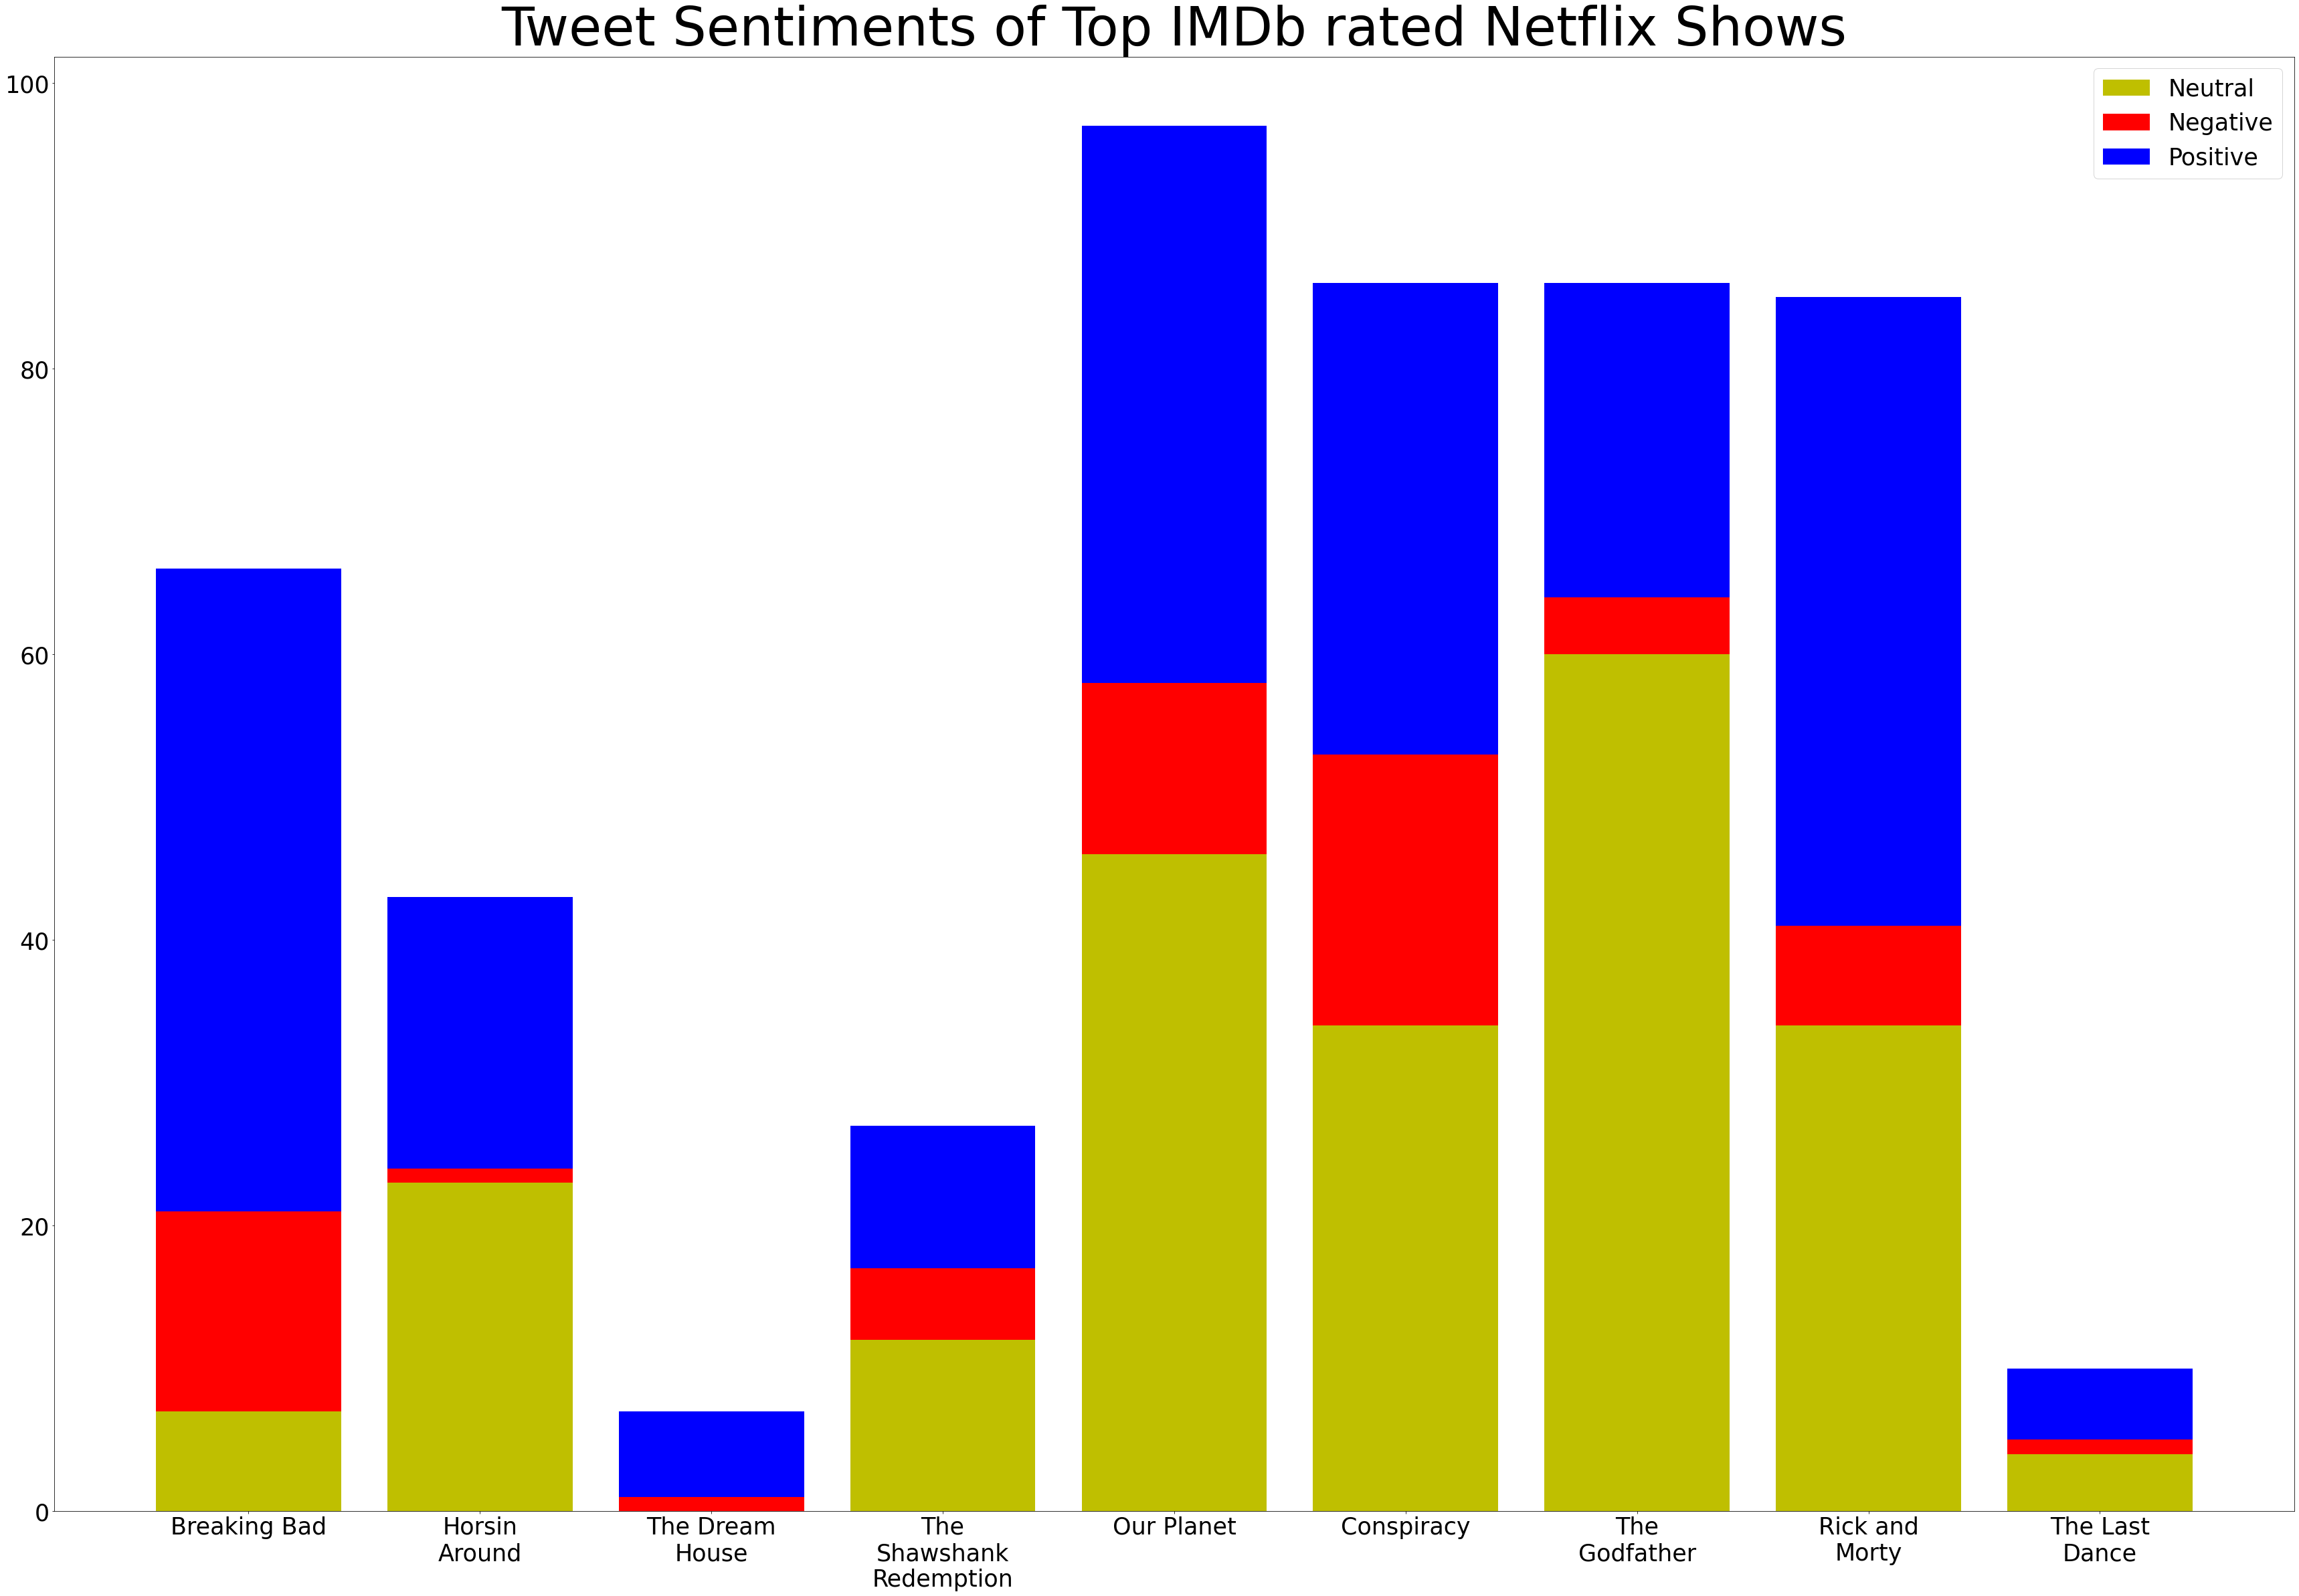

In [17]:
x = netflix_data['Title']
x = ['\n'.join(wrap(x, 12)) for x in x]
y1 = netflix_data['positive_sentiments_count']
y2 = netflix_data['negative_sentiments_count']
y3 = netflix_data['neutral_sentiments_count']
  
# plot bars in stack manner
plt2.bar(x, y3, color='y')
plt2.bar(x, y2, bottom=y3, color='r')
plt2.bar(x, y1, bottom=y2+y3, color='b')
plt2.title("Tweet Sentiments of Top IMDb rated Netflix Shows",fontdict = {'fontsize' : 80})
plt2.legend(["Neutral", "Negative", "Positive"], prop={'size': 35})
plt2.tick_params(axis='x', which='major', labelsize='35')
plt2.tick_params(axis='y', which='major', labelsize='35')
plt2.rcParams['figure.figsize']=(60,40)
plt2.show()

### ANALYSIS:
The nine movies and shows we have are globally popular; people from different countries watch them and have their own sentiments even though we believe the majority of the gathered tweets may be from the US. The sentiments gathered are representative of content popularity and content rating; they are thus important in understanding Netflix's global perception and expansion. We can extrapolate these sentiments and apply them to non-english speaking consumers. We also believe these tweets would be a good way to measure content popularity and success in countries across the world. It is important to recognize the limitations in only English tweets though. Opinions can vary based on location but Netflix has been working with that problem for years and ideally wants all consumers to enjoy content the same.

These sentiments help with understanding growth strategy - the shows and movies above are among Netflix's most popular to offer - the streaming service will often include them in various countries they want to see growth in. Netflix can also include popular shows and movies in countries that are being introduced to the service for the first time. We believe United States' influence in television entertainment is critical here. It can be used to have a direct association with Netflix as a company and offer international members content they are likely to enjoy, based on the sentiments, to hold them as members. In other words members may remain members just for being provided consistently popular shows - platforms like Twitter can keep them connected together to discuss how they feel about the content - and Netflix may then again understand how to maintain members based on their content's popularity. Maintaining a check on global popularity is likely the most difficult tactic but it is a good method to see how quality content drives expansion and memberships.

We know the quantity of content is an emphasis for Netflix too so the focus on quality here is only a piece of their strategy. What we show here most importantly is raw popularity trends in content and our attempt to see some of the more unique tactics Netflix has been practicing to expand.

## Lastly, we analyze the relation between Hidden Gem score, IMDb & Rotten Tomatoes

In [18]:
# Scrape Rotten Tomatoes to get Tomatometer scores since most of the original data lack those scores. After that, we can analyze ratings on IMDb and Rotten Tomatoes. 
count = 0
for index, row in df_data[['Title','Series or Movie','Rotten Tomatoes Score']][df_data['IMDb Score'].notnull() & df_data['Rotten Tomatoes Score'].isnull()].iterrows():
    # ScraperApi handles proxy rotation with each free trial providing 5,000 free requests. An API request will fail once it exceeds free requests limitations.
    if (index % 2) == 0:
        api = 'ae11f9b1514bf6f1bf1731f5149e345d'
    else:
        api = 'dfb8b29d015c47938f183464248f809e'
    url = 'http://api.scraperapi.com?api_key=' + api +'&url=https://www.rottentomatoes.com/search?search=' + urllib.parse.quote(row[0])
    # Extract Data from HTML     
    result = requests.get(url)
    count += 1
    soup = BeautifulSoup(result.text, "html.parser")
    # Match the form title on Rotten Tomatoes search results pages
    if row[1] == 'Series':
        content = soup.find("h2", text = "TV shows")
    elif row[1] == 'Movie':
        content = soup.find("h2", text = "Movies")      
    else:
        continue        
    # Create a regular expression from the title column to match titles on search results pages, then get the Rotten Tomatoes scores from the search result if it exists
    pattern = re.compile(re.escape(row[0]), re.I)
    if content is None:
        df_data.loc[index,'Rotten Tomatoes Score'] = np.nan
    else:
        for title in content.find_next("ul").find_all('search-page-media-row'):
            if bool(pattern.match(title.select_one("[data-qa=info-name]").get_text().lstrip().rstrip())):
                if title['tomatometerscore'] != "":
                    df_data.loc[index,'Rotten Tomatoes Score'] = title['tomatometerscore']
                brea       

**Export a CSV file once finished data scraping**
- we export the csv because the API used for scraping the Tomatometer data can be used only for a limited number of times. We extracted the data and exported it into a csv file. We will further be importing it for our analysis.

In [19]:
df_data.to_csv('netflix_rt.csv', encoding='utf-8', index=False)

## <center> Hidden Gems </center>
In this dataset, we found a feature called "Hidden Gem Score" and we wanted to know what it indicates. We as a group were curious to know what this score means as we all have already seen IMDb and Rotten Tomatoes on the internet but never heard of a Hidden Gem score.<br> We scrapped the data from the internet for Rotten Tomato scores as we needed it to build an analysis around the Hidden Gem score. 
Our analysis about the Hidden Gem is based on below factors:
- **Tomatometer score** is generated from a team of curators who collect movie and TV reviews from Tomatometer-approved critics and publications. 
- **IMDb score** is derived from votes submitted by IMDb users, these ratings come solely from users.
- **Top Award winning Hidden Gem Movies**

In [20]:
# Select the top 100 award-winning hidden gem movies, comparing its IMDb score with rotten tomatoes score.
df_netflix_data = pd.read_csv('netflix_rt.csv', engine='python', encoding='latin')
df_score = df_netflix_data[df_netflix_data['Hidden Gem Score'].apply(lambda x : bool(re.search('\d+', str(x))))].dropna(subset=['IMDb Score', 'Rotten Tomatoes Score'])
df_movie = df_score[df_score['Series or Movie'] == 'Movie'][['Title','Hidden Gem Score','IMDb Score','Rotten Tomatoes Score', 'Awards Received']].reset_index(drop=True)
df_movie['Awards Received'].fillna(0, inplace=True)
df_award_movie = df_movie[df_movie['Awards Received']>0].sort_values(by='Hidden Gem Score', ascending=False)[:100]

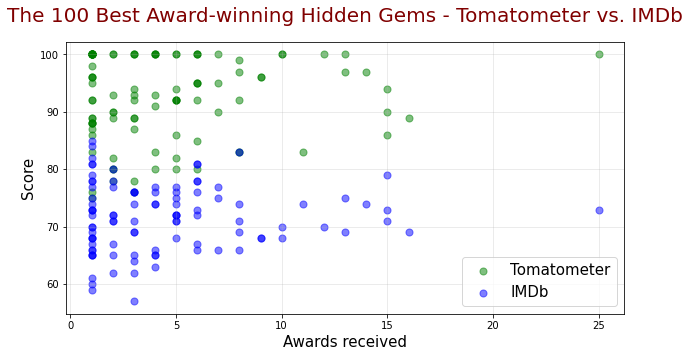

In [21]:
# compare the IMDb score & Tomatometer of each movies to find potential relations
fig, ax = plt.subplots(figsize=(10,5))

ax.set_xlabel('Awards received', fontsize=15)
ax.set_ylabel('Score', fontsize=15)
ax.set_title('The 100 Best Award-winning Hidden Gems - Tomatometer vs. IMDb', fontdict={'fontsize': 20, 'fontweight': 500, 'color': 'maroon'}, pad=20)
ax.grid(alpha = 0.3)

ax.scatter(x=df_award_movie['Awards Received'], y=df_award_movie['Rotten Tomatoes Score'], color='green',s = 50, alpha = 0.5, label = 'Tomatometer')
ax.scatter(x=df_award_movie['Awards Received'], y=df_award_movie['IMDb Score']*10, color='blue',s = 50, alpha = 0.5, label = 'IMDb')
plt.legend(loc='best', fontsize=15);

plt.show()

### ANALYSIS : 

The scatter plot shows that hidden gems usually have a better review on Rotten Tomatoes than on the IMDb database. We can infer that hidden gems are not eye-catching movies, so most of them might fail to get high ratings from general audiences. Nevertheless, these movies are appreciated by critics and get reliable reviews on Rotten Tomatoes.
- The "Hidden gem score" feature can discover movies that are critically acclaimed by trusted critics but unpopular to the general audiences.
- Netflix can adopt this parameter on its recommendation algorithm to find out the lesser-known movies people might have missed but must be watching and suggesting to their customers.

## <center> CONCLUSION </center>

This project has answered a lot of our questions.

1) We see that Netflix goes beyond Localization in the Word Cloud. In spite of a lot of challenges from over content in countries like Australia and Kenya, Netflix has now a foot in over 190 countries. The streaming platform is available in almost all countries except China, North Korea, and Syria being exceptions. <br> Ref: https://www.daytranslations.com/blog/netflix-international-expansion/<br> 
2) In a 2014 article, Wendy Syfret a freelance writer mentioned: “I think Netflix will face a much stiffer test in France and Germany because of the language issue”. However, The graph shows a great improvement so as to how over the years Netflix has just proven to change its course of action from 2014. The content is availed in majority of the languages.  <br> Ref: https://www.reuters.com/article/us-netflix-europe/netflix-takes-on-language-challenge-in-next-phase-of-european-expansion-idUSKBN0H71SJ20140912 <br>
3) Twitter is no more a social media platform, we can say it's a great crowdsourcing tool for generating ideas, driving engagement and promoting content. While analyzing the highest rated IMDb shows, we wanted to see are people's sentiments actually inline with the scores we have. Looks like Twitter is a great metric that is proportional to the IMDb scores but then we had certain interesting results. An outlier which showed negative sentiment about a Highest rated IMDb Movie made us question the possibility of using Twitter. But later we figured out that there can be different possibilities to it. There can be a vivid chance of including more words in the sentiment library to make it more accurate since the outlier was minimal in the entire shows and tweets we analysed. But if Twitter is such a great tool to promote Netflix content, why isn't a score being assigned yet just on the basis of what people tweet? This is one interesting question that we can ask Netflix. <br> Ref: https://digitalcommons.calpoly.edu/cgi/viewcontent.cgi?article=1057&context=statsp <br> 
4) When we extracted the dataset, we could see a Hidden Gem column and that intrigued us as we have never heard of such a concept. We scrapped the web for Tomatometer scores and analysed 4 parameters to know that Hidden Gems are actually Gems that go unnoticed on Netflix. They are critically acclaimed but unpopular shows. We believe this is a segment that Netflix can work on to drive business value. They can have premium memberships to access Hidden Gems or bundle it with some seasonal offer to capture the interest of Movie lovers. They can drive campaigns on social media platforms like Twitter to promote such Hidden Gems and drive more engagement on their Platform.